In [6]:
import numpy as np
from __future__ import division

class Transformations(object):
    """since these transformations are all related, we'll nest them all under a feature norm class"""
    def mean_at_zero(self, arr):
        return np.array([i - np.mean(arr) for i in arr])
        """range where 0 represents the mean"""

    def norm_to_min_zero(self, arr):
        return np.array([i / max(arr) for i in arr])
        """a range from 0 to 1, where """"
    
    def norm_to_absolute_min_zero(self, arr):
        return np.array([(i - min(a)) / (max(a) - min(a)) for i in arr])
        """a range of 0 to 1, where 0 maintains its 0 value"""
    
    def norm_to_neg_pos(self, arr):
        return np.array([(i - np.mean(arr)) / (max(arr) - np.mean(arr)) for i in arr])
        """a range of -1 to 1, where 0 represents the mean"""
    
    def norm_by_std(self, arr):
        return np.array([(i - np.mean(arr)) / np.std(arr) for i in arr])
        """a range where 0 represents the mean, split by standard deviation"""

In [7]:
## tests to make sure we built this correctly:
transformer = Transformations()

a = np.array([1.0, 2.0, 3.0, 4.0, 5.0])

print transformer.mean_at_zero(a) == np.array([-2, -1, 0, 1, 2])
print transformer.norm_to_min_zero(a) == np.array([0.2, 0.4, 0.6, 0.8, 1.0])
print transformer.norm_to_absolute_min_zero(a) == np.array([0.0, 0.25, 0.5, 0.75, 1.0])
print transformer.norm_to_neg_pos(a) == np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
print transformer.norm_by_std(a) == np.array([-1.414213562373095, -0.7071067811865475, 0.0, 0.7071067811865475, 1.414213562373095])

[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]


In [8]:
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

class PowerLaw(object):
    def fit(self, x, y, transform=True):
        """
        returns back the amplitude and index of a powerlaw relationship.
        assumes the data is not already log10 transformed.
        return: [index, amp], also stored on the instance
        """
        if transform:
            x = np.log10(x)
            y = np.log10(y)
        # define our (line) fitting function and error function to optimize on
        fitfunc = lambda p, x: p[0] + p[1] * x
        errfunc = lambda p, x, y: (y - fitfunc(p, x))
        # defines a starting point to optimize from.
        p_init = [1.0, -1.0] 
        out = sp.optimize.leastsq(errfunc, p_init, args=(x, y), full_output=1)
        result = out[0]
        self.index = result[1]
        self.amp = 10.0**result[0]
        return np.array([self.amp, self.index])
    
    def transform(self, x):
        """returns the x-transformed data"""
        return self.amp * (x**self.index)

In [17]:
import pandas as pd
from sklearn import tree
from sklearn.cross_validation import cross_val_score

# Load in data and create sets. dropping all na columns on the live data set.
lemons = pd.read_csv('../DAT18NYC/data/lemons.csv')
lemons_oos = pd.read_csv('../DAT18NYC/data/lemons_oos.csv')
print lemons.dtypes

RefId                                  int64
IsBadBuy                               int64
PurchDate                             object
Auction                               object
VehYear                                int64
VehicleAge                             int64
Make                                  object
Model                                 object
Trim                                  object
SubModel                              object
Color                                 object
Transmission                          object
WheelTypeID                          float64
WheelType                             object
VehOdo                                 int64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrent

In [18]:
lemons = lemons.dropna(axis=1)
# Generating a list of continuous data features from the describe dataframe. 
# Then, removing the two non-features (RefId is an index, IsBadBuy is the prediction value)
features = list(lemons.describe().columns)
features.remove('RefId')
features.remove('IsBadBuy')

best_score = -1
for depth in range(1, 10):
    scores = cross_val_score(tree.DecisionTreeClassifier(max_depth=depth, random_state=1234),
                                lemons[features],
                                lemons.IsBadBuy,
                                scoring='roc_auc',
                                cv=5)
    if scores.mean() > best_score:
        best_depth = depth
        best_score = scores.mean()

# Is the best score we have better than each DummyClassifier type?
from sklearn import dummy, metrics
for strat in ['stratified', 'most_frequent', 'uniform']:
    dummyclf = dummy.DummyClassifier(strategy=strat).fit(lemons[features], lemons.IsBadBuy)
    print 'did better than %s?' % strat, metrics.roc_auc_score(lemons.IsBadBuy, dummyclf.predict(lemons[features])) < best_score

did better than stratified? True
did better than most_frequent? True
did better than uniform? True


In [19]:
print lemons.groupby('Auction').Auction.count()
print lemons.groupby('Auction').IsBadBuy.mean()

# seems like the ADESA auction is particularly worse for bad buys (about 36% more)
# it may help to create a new column that specically refers to "is_adesa"

lemons['auct_adesa'] = lemons.Auction.apply(lambda x: 1 if x == 'ADESA' else 0)

print lemons.groupby('auct_adesa').IsBadBuy.mean()

Auction
ADESA      10128
MANHEIM    28645
OTHER      12315
Name: Auction, dtype: int64
Auction
ADESA      0.153732
MANHEIM    0.114400
OTHER      0.118149
Name: IsBadBuy, dtype: float64
auct_adesa
0             0.115527
1             0.153732
Name: IsBadBuy, dtype: float64


(array([  1.00000000e+00,   2.15900000e+03,   5.93600000e+03,
         1.11580000e+04,   1.19690000e+04,   9.06400000e+03,
         5.57700000e+03,   3.23400000e+03,   1.53200000e+03,
         4.58000000e+02]), array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]), <a list of 10 Patch objects>)
VehicleAge
0             0.000000
1             0.044465
2             0.062163
3             0.083259
4             0.110118
5             0.146293
6             0.180384
7             0.219852
8             0.253916
9             0.316594
Name: IsBadBuy, dtype: float64


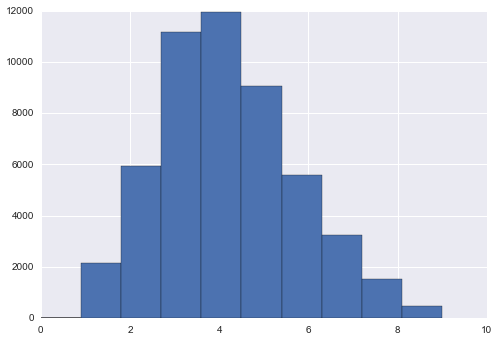

In [20]:
print plt.hist(lemons.VehicleAge)

print lemons.groupby('VehicleAge').IsBadBuy.mean()

# there seems to be a stronger relationship with bad buys as vehicles are older.
# is there anything we should do here?

In [25]:
lemons.describe()

,RefId,IsBadBuy,VehYear,VehicleAge,VehOdo,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost,auct_adesa
count,51088.000000,51088.000000,51088.000000,51088.000000,51088.000000,51088.000000,51088.000000,51088.000000,51088.000000,51088.000000,51088.000000
mean,36618.299503,0.123101,2005.345893,4.172780,71550.864880,26376.254913,58154.511764,6728.222272,0.025035,1276.712320,0.198246
std,21047.637595,0.328557,1.727976,1.709315,14610.426618,25727.370369,26148.295399,1768.991083,0.156234,600.140901,0.398682
min,1.000000,0.000000,2001.000000,0.000000,5368.000000,835.000000,2764.000000,1.000000,0.000000,462.000000,0.000000
25%,18479.250000,0.000000,2004.000000,3.000000,61866.750000,17212.000000,32124.000000,5425.000000,0.000000,837.000000,0.000000
50%,36685.000000,0.000000,2005.000000,4.000000,73434.500000,19662.000000,74135.000000,6700.000000,0.000000,1169.000000,0.000000
75%,54851.500000,0.000000,2007.000000,5.000000,82478.000000,22808.000000,80022.000000,7900.000000,0.000000,1623.000000,0.000000
max,73013.000000,1.000000,2010.000000,9.000000,115717.000000,99761.000000,99224.000000,38785.000000,1.000000,7498.000000,1.000000


In [27]:
# feature selection
from sklearn import feature_selection as f_select

y = lemons.IsBadBuy

significant_features = []
pvals = []
for feature in lemons:
    pval = f_select.f_classif(lemons[feature],y)
    if pval[1][0] < 0.05:
        significant_features.append(feature)
        pvals.append(pval[1][0])

ValueError: invalid literal for float(): 12/2/2009